In [327]:
%matplotlib inline
%config InlineBackend.figure_format='svg'
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import pandas as pd
import os

from operator import attrgetter
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from os.path import isfile, join

asdf

In [328]:
# These functions are used for data analysis.

# these functions are used in determining the type
# of data we are looking at (posthresh, neghold etc)
def is_increasing(L):
    return L[0] < L[len(L) - 1]
def is_decreasing(L):
    return L[0] > L[len(L) - 1]
def non_increasing(L):
    return all(x>=y for x, y in zip(L, L[1:]))
def non_decreasing(L):
    return all(x<=y for x, y in zip(L, L[1:]))
def monotonic(L):
    return non_increasing(L) or non_decreasing(L)
def average(array):
    return sum(array) / len(array)

# this will return the type of data you give it
# it takes an array of voltages and currents as arguments
def sort_into_side(voltage, current):
    if is_increasing(voltage) and is_increasing(current):
        return "posThresh"
    elif is_decreasing(voltage) and is_decreasing(current):
        return "posHold"
    elif is_decreasing(voltage) and is_increasing(current):
        return "negThresh"
    elif is_increasing(voltage) and is_decreasing(current):
        return "negHold"
    else: 
        print("???")
        # print("error determining type of data. V: ", voltage, " I: ", current)

def get_rand_id():
    return np.random.randint(1000000000)

def get_default(value, delfault):
    return value if value is not None else delfault

asdf

In [329]:
class Graph: 
    def __init__(self, title, xlabel, ylabel, hlines, type_of_graph, data_to_graph):
        # print(props)
        self.size = [18, 6]
        self.title = title
        self.xlabel = xlabel
        self.ylabel = ylabel
        self.hlines = hlines
        self.type = type_of_graph
        self.data_to_graph = data_to_graph

    def show(self):
        plt.rcParams['figure.figsize'] = (self.size[0], self.size[1])
        plt.title(self.title)
        plt.xlabel(self.xlabel)
        plt.ylabel(self.ylabel)
        plt.grid()

        for i in range(len(self.hlines)):
            plt.axhline(y = self.hlines[i], color = 'r', linestyle = '-')

        if self.type == "semilogy":
            for i in range(len(self.data_to_graph) - 0):
                plt.semilogy(self.data_to_graph[i][0], self.data_to_graph[i][1])
            
        plt.figure(get_rand_id())
        plt.show()

asdf

In [330]:
# this will take a file name
# get all of the meaningful stuff out of it
class DataFile:
    def __init__(self, file_path):
        self.pos_hold_voltages = []
        self.neg_hold_voltages = []

        self.pos_thresh_voltages = []
        self.neg_thresh_voltages = []
        self.filePath = file_path
        self.get_file_name_from_path()
        self.get_device_number_from_name()
        self.get_sample_number_from_name()
        self.read_all_data()
        self.break_all_data_into_IV_curves()
        self.sort_data_into_types()

        # self.sort_runs_into_neg_pos_thresh_hold()

        # self.graph_all_data()

    def get_file_name_from_path(self):
        self.file_name = self.filePath.split("/GitHub/")[1]

    def get_device_number_from_name(self):
        self.device_number = self.file_name.split("_")[4]

    def get_sample_number_from_name(self):
        self.sample_number = self.file_name.split("_")[3]

    def read_all_data(self):
        # REMOVE BAD DATA: read all the data and remove the rows when we are very close to the max current
        rows_to_exclude = pd.read_csv(self.filePath, names=['Time (s)','Current (A)','Voltage (V)', 'Temperature (K)'], sep='\t',skiprows=1)
        data = rows_to_exclude.values
        rows_to_exclude.head()
        I_to_skip = data[:,1]
        # the cut off value for the max current is 0.99 * the highest current recorded in the file
        self.max_current = np.max(I_to_skip) * 0.99
        over_max_current_indexes = ((I_to_skip > self.max_current).nonzero())[0]


        # read the file again without the rows that have a current above the threshold
        df5 = pd.read_csv(self.filePath, names=['Time (s)','Current (A)','Voltage (V)', 'Temperature (K)'], sep='\t',skiprows=over_max_current_indexes)
        data = df5.values
        df5.head()
        
        self.number_of_data_points = len(data[:,0])
        print("number of data points: ", self.number_of_data_points)
        
        # self.time = data[:,0]
        interval = average(np.gradient(data[:,0][1:5]))
        # interval = 1
        self.time = np.arange(0, len(data[:,0])) * interval

        self.I = data[:,1]
        self.V = data[:,2]
        self.temps = data[:,3]

        self.R = self.V / self.I
        self.R = np.abs(self.R)

    def graph_all_data(self):
        the_graph = Graph(
            "All Data",         # title
            "Voltage (V)",      # xlabel
            "Current (A)",      # ylabel
            [self.max_current], # hlines
            "semilogy",         # type of graph
            [[self.V[50:100], self.I[50:100]]],   # data to graph
        )
        the_graph.show()

    def break_all_data_into_IV_curves(self):
        # get the index of every "0" value in the voltage array
        self.all_zero_indexes = np.where(self.V == 0.0)[0]

        # removing the frist and last 4 reduces the number of crashing
        self.all_zero_indexes = self.all_zero_indexes[4:]
        self.all_zero_indexes = self.all_zero_indexes[:-4]


        self.IV_curves = []
        self.all_data_in_runs = []
        for i in range(len(self.all_zero_indexes) - 1):
            start = self.all_zero_indexes[i]
            stop = self.all_zero_indexes[i+1] 

            dI = np.gradient(self.I[start:stop])
            ddI = np.gradient(np.gradient(self.I[start:stop]))
            run_temp = np.average(self.temps[start:stop])
            run_temp_std = np.std(self.temps[start:stop])
            
            self.IV_curves.append({
                'time': self.time[start:stop],
                'I': self.I[start:stop],
                'dI': dI,
                'ddI': ddI,
                'V': self.V[start:stop],
                'temps': self.temps[start:stop],
                'temp': run_temp,
                'temp_std': run_temp_std,
            })

        self.number_of_IV_curves = len(self.all_zero_indexes) - 1
        print("number of IV curves: ", self.number_of_IV_curves)

    def sort_data_into_types(self):
        for IV_curve in self.IV_curves:
            print(sort_into_side(IV_curve['V'], IV_curve['I']))

    def graph_IV_curve(self, index):
        title_time = "  Time =" + str(round(self.IV_curves[index]['time'][0], 3)) + " s"
        title_temp = "  Temp =" + str((self.IV_curves[index]['temps'][0])) + " K" + " Std: " + str(round(self.IV_curves[index]['temp_std'], 3))
        title = "IV curve # " + str(index) + title_time + title_temp

        the_graph = Graph(
            title,              # title
            "Voltage (V)",      # xlabel
            "Current (A)",      # ylabel
            [], # hlines
            "semilogy",         # type of graph
            [[self.IV_curves[index]['V'], self.IV_curves[index]['I']]],   # data to graph
        )
        the_graph.show()

        plt.rcParams['figure.figsize'] = (9,3)
        plt.grid()

        colors = ['red', 'blue', 'orange', 'green']
        # data_sets = [self.pos_hold_runs[run_to_graph], self.neg_hold_runs[run_to_graph], self.pos_thresh_runs[run_to_graph], self.neg_thresh_runs[run_to_graph]]
        data_sets = []
        data_sets.append(self.neg_hold_runs[index])
        data_sets.append(self.pos_hold_runs[index])
        data_sets.append(self.pos_thresh_runs[index])
        data_sets.append(self.neg_thresh_runs[index])
        
        # there are 4 types of runs - posThresh, posHold, negThresh, negHold
        for i in range(4):
            xAxis = data_sets[i]['V']
            yAxis = data_sets[i]['I']
            point_index = np.argmax(data_sets[i]['ddI'])
            if i == 0: 
                point_index-=2
            if i == 1: 
                point_index-=2
            if i == 2: 
                point_index+=1
            if i == 3: 
                point_index+=0
            plt.plot(xAxis[point_index], yAxis[point_index], marker="o", markersize=10, markeredgecolor=colors[i], markerfacecolor=colors[i])
            plt.semilogy(xAxis, yAxis, color=colors[i])

        plt.xlabel('Voltage (V)')
        plt.ylabel('Current (A)')
        plt.figure(np.random.randint(1000000000))


asdf

number of data points:  201871
number of IV curves:  2637
posThresh
negThresh
posThresh
posThresh
negThresh
posThresh
negThresh
posThresh
negThresh
posThresh
posThresh
negThresh
posThresh
negThresh
posThresh
negThresh
posThresh
negThresh
posThresh
negThresh
posThresh
negThresh
posThresh
negThresh
posThresh
negThresh
posThresh
negThresh
posThresh
negThresh
posThresh
negThresh
posThresh
negThresh
posThresh
negThresh
posThresh
negThresh
posThresh
negThresh
posThresh
negThresh
posThresh
negThresh
posThresh
negThresh
posThresh
negThresh
posThresh
negThresh
posThresh
negThresh
posThresh
negThresh
posThresh
negThresh
posThresh
negThresh
posThresh
negThresh
posThresh
negThresh
posThresh
negThresh
posThresh
negThresh
posThresh
negThresh
posThresh
negThresh
posThresh
negThresh
posThresh
negThresh
posThresh
negThresh
posThresh
negThresh
posThresh
negThresh
posThresh
negThresh
posThresh
negThresh
posThresh
negThresh
posThresh
negThresh
posThresh
negThresh
posThresh
negThresh
posThresh
negThresh
po

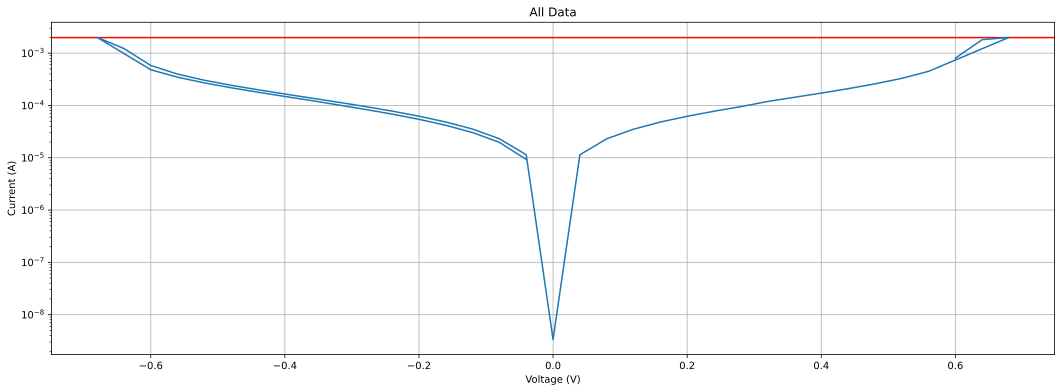

<Figure size 1800x600 with 0 Axes>

In [331]:
theFile = DataFile("c:/Users/Ted Mburu/Documents/GitHub/Nb02_v2/IVs_NbO2_Ti0_Sam3_052423_D15_cool.txt");

theFile.graph_all_data()

# number_of_graphs = 10
# for x in range(0, number_of_graphs):
#   # number_of_IV_curves = theFile.number_of_IV_curves * 1
#   i = (int)((theFile.number_of_IV_curves / number_of_graphs) * x)
#   theFile.graph_IV_curve(i)